The objective of this assignment is to reveal underlying patterns from image dataset. To achieve this goal I have applied an unsupervised Deep Learning method, specifically Convolutional Neural Networks (CNN) and analyze data. The reason it is unsupervised as we have unlabeled images which need to find some sort of patterns, like clustering. I have used a computer vision algorithm called “Convolutional Autoencoder” to solve this problem.

The architecture of this network design is symmetric about centroid and number of nodes reduce from left to centroid, they increase from centroid to right. Centroid layer would be compressed representation. 

In [37]:
# import necessary modules

from os.path import join
from os import listdir
import glob

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2

import keras
from keras.preprocessing.image import load_img, img_to_array 
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D
from keras import backend as K

import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns

%matplotlib inline

In [2]:
print("Sklearn version: " + str(sklearn.__version__))
print("keras version: " + str(keras.__version__))
print("numpy version: " + str(np.__version__))
print("pandas version: " + str(pd.__version__))

Sklearn version: 0.23.2
keras version: 2.4.3
numpy version: 1.18.5
pandas version: 1.1.1


# Load and pre-process

First I load the data and do some image preprocessing for modeling.

The preprocessing has done on three steps:

1. Resize the image to (224, 224) - for simpler pooling in the autoencoder (224 can be divided by 2 more times, and stay integer)
2. Convert the binary string to arrary of numbers.
2. Normalize the numbers from value from 0 to 255 for each pixel, to 0 to 1.

In [3]:
image_dir = './dataset/'
img_paths = [join(image_dir, filename) for filename in listdir(image_dir)]

## Loades Image paths are not sorted, which we can sort them using the below functions
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


# Sort the images according to their numbers

img_paths.sort(key= natural_keys) 


# Function to Read and Prep Images for Modeling

image_size = 224
channels = 3

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size, channels=channels):
    
    image_list = np.zeros((len(img_paths), img_height, img_width, channels))
    
    for i, fig in enumerate(img_paths):
        
        img = load_img(fig,  target_size=(img_height, img_width))
        img_array = img_to_array(img).astype('float32')
        x = img_array / 255.0 # Normalize between 0 and 1
        image_list[i] = x
    
    return image_list


# Call the function to load and preprocess images
img_data = read_and_prep_images(img_paths)

print("Load images successfull.\n")



Load images successfull.



# Split the dataset

In [4]:
# Split the data into train and validation sets

print("Spliting into train and validation sets.\n")

def train_val_split(x):
    rnd = np.random.RandomState(seed=42)
    perm = np.random.permutation(len(x))
    train_idx = perm[:int(0.7 * len(x))] # 70% data for trainining and 30% images for validation
    val_idx = perm[int(0.7 * len(x)):]
    return x[train_idx], x[val_idx]

x_train, x_val = train_val_split(img_data)
print("Train shape: {} \nTest shape: {} " .format(x_train.shape, x_val.shape))

#x = np.concatenate([x_train, x_val])
#x= (x*255).astype(np.uint8)

Spliting into train and validation sets.

Train shape: (698, 224, 224, 3) 
Test shape: (300, 224, 224, 3) 


In [19]:
from sklearn.model_selection import train_test_split

train_X,valid_X,train_ground,valid_ground = train_test_split(img_data,
                                                             img_data, 
                                                             test_size=0.3, 
                                                             random_state=13)

# Note that for this task, you don't need training and testing labels. That's why you will pass the training images twice. 
# Your training images will both act as the input as well as the ground truth similar to the labels you have in classification task.

## Visualize the data

Here are the first 9 images from the dataset.

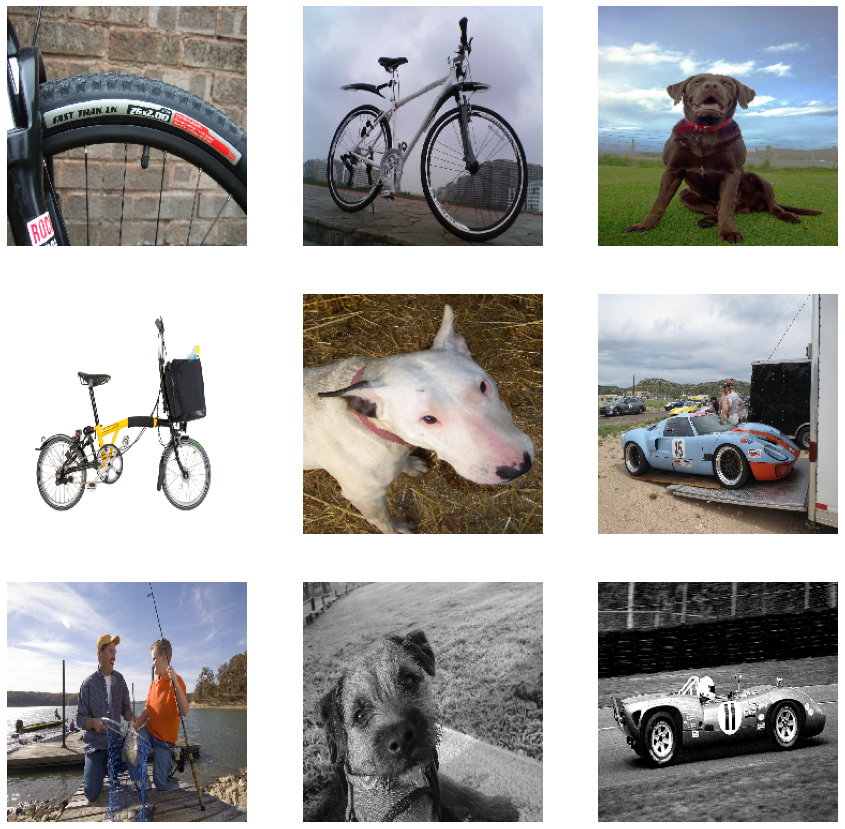

In [5]:
plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_data[i])
    plt.axis("off")

plt.savefig("./9_images.png")

# Convolution autoencoder

In this pattern recognition task, I have used unsupervised computer vision algorithm autoencoder to solve the problem. Among many techniques used to recognize images as multilayer perceptron model, Convolution Neural Network (CNN) appears as a very efficient one. In this assignment, I build a CNN Autoencoder and apply it on our image dataset.

Model expects x_train 2 times as input and output because we try to restore the input almost lossless. If it can be restored with little loss, then middle part of the network model stores significant but smaller data. That is the idea behind autoencoders.


In [38]:
# Create a class for our Autoencoder network

class Autoencoder():
    def __init__(self):
        self.img_rows = 224
        self.img_cols = 224
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        optimizer = RMSprop() # Adam(lr=0.001)
        
        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='mean_squared_error', optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.img_shape)
                
        # encoder
        conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer) # 224 x224 x32
        pool1 = MaxPooling2D((2, 2), padding='same')(conv1)                        # 112 x 112 x 32
        
        conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)       # 112 x 112 x 64          
        pool2 = MaxPooling2D((2, 2), padding='same')(conv2)                        # 56x 56 x 64
        
        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)      # 56x 56 x 128 
        pool3 = MaxPooling2D((2, 2), padding='same')(conv3)                        # 28 x28 x128
        
        conv4 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool3)       # 28x 28 x 16 (small and thick)
       
        # decoder
        conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv4)       # 28x 28 x 16
        up1 = UpSampling2D((2, 2))(conv5)                                          # 56 x 56 x 16
        
        conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)         # 56 x 56 x 128
        up2 = UpSampling2D((2, 2))(conv6)                                          # 112 x 112 x 128
        
        conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)         # 112 x 112 x 64
        up3 = UpSampling2D((2, 2))(conv7)                                          # 224 x 224 x 64
        
        output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3) # 224 x224X3
        
        return Model(input_layer, output_layer)
    
    def train_model(self, x_train, x_val, epochs, batch_size=20):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, x_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, x_val),
                                             callbacks=[early_stopping])
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds
    
    

In [30]:
(224*224*3)/(28*28*16)

12.0

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 28, 128)      

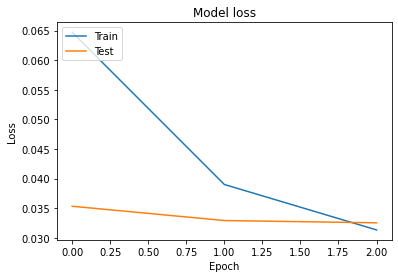

In [39]:
# Create a object from our previous Autoencoder class and fit it on trian data

ae = Autoencoder()
ae.train_model(x_train, x_val, epochs=50, batch_size=20)


In [9]:
# Let’s visualize some restorations.

restored_imgs = ae.autoencoder_model.predict(x_train)
#restored_imgs =restored_imgs.reshape(224,224,3)


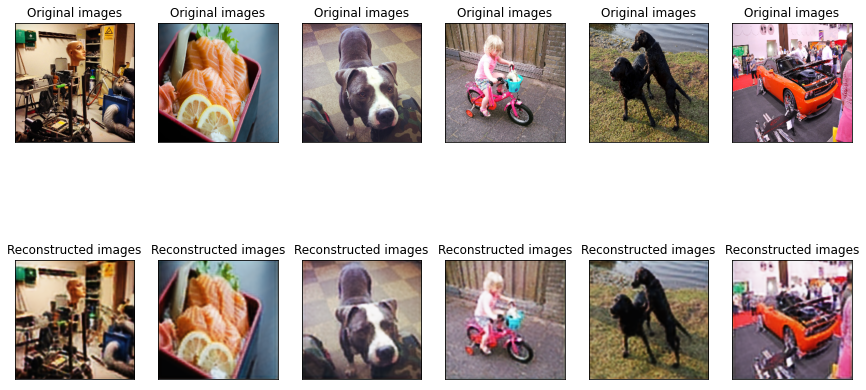

In [11]:
# Visualize the reconstructed inputs and the encoded representations. use Matplotlib

n = 6 # How many origina images we will display
plt.figure(figsize= (15,8))

for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow((x_train[i] * 255).astype(np.uint8))
    ax.set_title("Original images")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow((restored_imgs[i] * 255).astype(np.uint8))
    ax.set_title("Reconstructed images")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig("./reconstructed_images.png")
plt.show()


    
    

### Save the model


In [87]:
# To save the model
model_json = ae.autoencoder_model.to_json()
with open("ae_model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("ae_model.h5")
print("Saved model")

Saved model


### Keras H5 format

Keras also supports saving a single HDF5 file containing the model's architecture, weights values, and compile() information. It is a light-weight alternative to SavedModel


In [12]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
#model.save("my_h5_model.h5")

ae.autoencoder_model.save('ae_model.hdf5')

### To load the model again

In [4]:
model = load_model('ae_model.hdf5')
print("Loaded model from file successful")

Loaded model from file successful


In [101]:
pred =model.predict(x_val)

### Testing
Restorations seems really satisfactory. Images on the top are original images whereas images on the bottom are restored from compressed representation.

Notice that 4th layer named max_pooling2d_2 states the compressed representation and it is size of (None, 56, 56, 8). This work reveals that we can restore 224×224x3 pixel image from 56x56x8 sized matrix with a little loss. In other words, compressed representation takes a 6 times less space to original image.

# Compressed Representations

We can also extract compressed representations.

In [14]:
compressed_layer = 4
model = ae.autoencoder_model

# Extract the encoder
get_4th_layer_output = K.function([model.layers[0].input], [model.layers[compressed_layer].output])

# Encode the testing set
compressed_images = get_4th_layer_output([x_val])[0]
 
#flatten compressed representation to 1 dimensional array
compressed_images = compressed_images.reshape(-1, 56*56*8)

In [15]:
distortions = []
cl = range(1,15)
for k in cl:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(compressed_images)
    distortions.append(kmeanModel.inertia_)


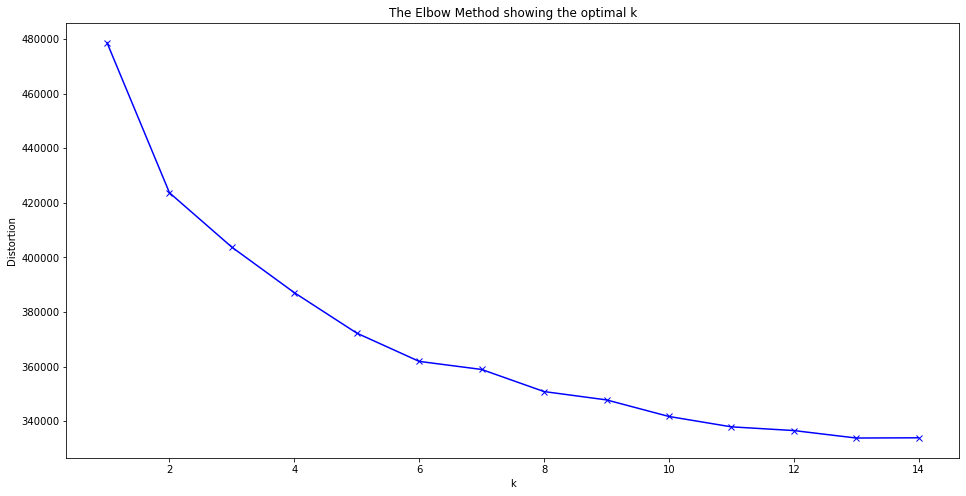

In [16]:
# Plotting the distortions of K-Means
plt.figure(figsize=(16,8))
plt.plot(cl, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The “elbow” method suggests for 5 or 6 number of clusters. Now we can run a K-Means setting n_clusters parameter as 6.

In [17]:
# Cluster the testing set
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, n_init=25, max_iter = 600, random_state= 123)
clusters = kmeans.fit_predict(compressed_images)

In [30]:
# Count the elements of the clusters
unique, counts = np.unique(clusters, return_counts=True)
dict(zip(unique, counts))

{0: 69, 1: 16, 2: 15, 3: 71, 4: 54, 5: 75}

There are 70 members in cluster 0
There are 79 members in cluster 1
There are 41 members in cluster 2
There are 35 members in cluster 3
There are 16 members in cluster 4
There are 59 members in cluster 5


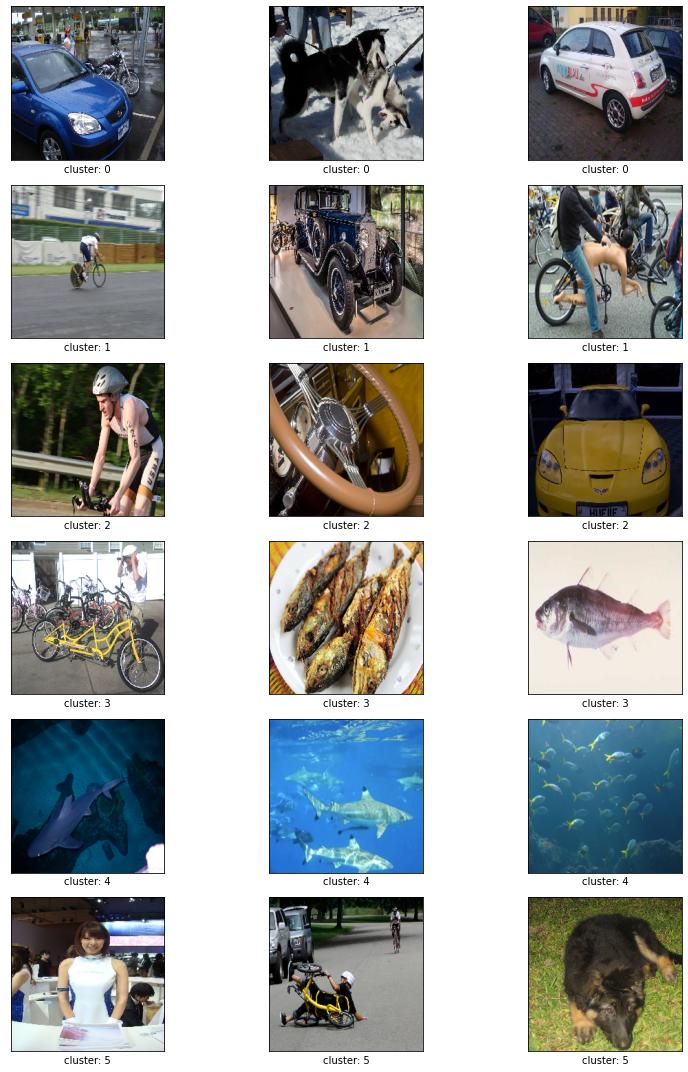

In [18]:
# Plot the actual pictures grouped by clustering

fig = plt.figure(figsize=(12,15))
n_clusters=6

for cluster in np.arange(n_clusters):
    cluster_member_indices = np.where(clusters == cluster)[0]
    print("There are %s members in cluster %s" % (len(cluster_member_indices), cluster))
    
    #random_member = np.random.choice(cluster_member_indices, size = num)
    # x_val[random_member[i],:,:,:]
    # take 3 images from each cluster
    for c, val in enumerate(x_val[cluster_member_indices,:,:,:][0:3]):
        i = 3*cluster+c+1 # max 18 plots
        fig.add_subplot(6, 3, i)
        plt.imshow(val)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        
plt.tight_layout()
plt.savefig("clustering_img.png", bbox_inches='tight')

plt.show()


Places to Improve
The following are few ideas that could be possible to make improvement of the model performance as well as its pattern recognition.
-	Using Conv2D Transpose layers rather than Upscaling layers.
-	Try with different loss function such as “Perceptual Loss” instead of MSE.
-	Try other optimizer instead of “Adam” optimizer.
-	Using more Convolutional Layers with Dynamic Regularization.
-	Increase training time, i.e., number of epochs.
